In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.fft import fft, fftfreq
from scipy.stats import norm
from scipy.signal import find_peaks, butter, sosfilt


Matplotlib is building the font cache; this may take a moment.


# Overview

All code based on instructions found in the [video here.](https://www.youtube.com/watch?app=desktop&v=jrWDBkeOVQY&t=516s&pp=2AGEBJACAQ%3D%3D)

# Data Loading
This code goes through each folder in 'Back_EMF_Data_Drill' and extracts all the csvs into a big dictionary 'dataframes'. The name and size of all of these entries are printed, ensure that all data is found before proceeding.

In [ ]:
# Directory containing the CSV files
repo_path = 'Back_EMF_Data_Drill'

# Dictionary to store DataFrames
dataframes = {}

for foldername in os.listdir(repo_path):
    folder_path = os.path.join(repo_path, foldername)
# Loop through all files in the directory
    for filename in os.listdir(folder_path):
        if filename.endswith('.CSV'):
            # Read the CSV file and skip the header row
            file_path = os.path.join(folder_path, filename)
            df_name = os.path.splitext(filename)[0]
            df = pd.read_csv(file_path, usecols=[3,4], header=None)
            times = df[3]
            times = [time_point+abs(times[0]) for time_point in times]
            voltages = df[4]
            # Store the lists in the dictionary
            dataframes[df_name] = {'times': list(times), 'voltages': list(voltages)}

dataframes = dict(sorted(dataframes.items()))

for experiment in dataframes:
    print(f"{experiment} has {len(dataframes[experiment]['times'])} data points")


BlueF0000CH2 has 2500 data points
BlueF0001CH2 has 2500 data points
BlueF0002CH2 has 2500 data points
BlueF0003CH2 has 2500 data points
BlueF0004CH2 has 2500 data points
RedF0001CH2 has 2500 data points
RedF0002CH1 has 2500 data points
RedF0002CH2 has 2500 data points
RedF0003CH2 has 2500 data points
RedF0004CH2 has 2500 data points
RedF0005CH2 has 2500 data points
YellowF0000CH1 has 2500 data points
YellowF0001CH1 has 2500 data points
YellowF0002CH1 has 2500 data points
YellowF0002CH2 has 2500 data points
YellowF0003CH1 has 2500 data points
YellowF0004CH1 has 2500 data points
YellowF0005CH1 has 2500 data points


In [3]:
def nice_plot_please(x, y, title, x_label, y_label):
    plt.figure(figsize=(5, 3))
    plt.plot(x, y,label="Voltage")
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)

def nice_plot_please_two(x1, y1, x2, y2, title, x_label, y_label,data_name1,data_name2):
    plt.figure(figsize=(5, 3))
    plt.plot(x1, y1,label=data_name1)
    plt.plot(x2, y2,label=data_name2)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show(block=False)

# Centering Data
Here each experiment is shifted up and down to centre around 0 and a dictionary "centred_data" is generated containing this..

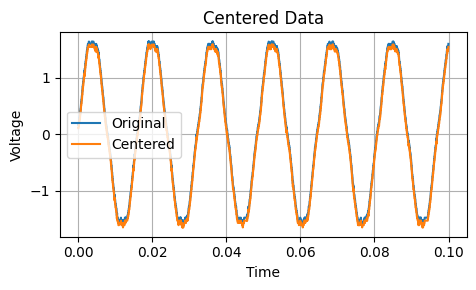

In [4]:
#dictionary of experiments, indexes as [value][0], 0 is time, 1 is voltage
example='RedF0001CH2'

#centering data about 0
centered_data = {}
for experiment in dataframes:
    mean = np.mean(dataframes[experiment]['voltages'])
    centered_data[experiment]= {'times': dataframes[experiment]['times'], 'voltages' : [v - mean for v in dataframes[experiment]['voltages']]}

#dictionary of experiments, indexes as [value][0], 0 is time, 1 is voltage
nice_plot_please_two(dataframes[example]['times'],dataframes[example]['voltages'],centered_data[example]['times'],centered_data[example]['voltages'],"Centered Data","Time","Voltage","Original","Centered")


In [5]:
def waveform_data_info(experiment,data=centered_data,window_start=0,window_size=0,voltage_threshold=.5,plot=False,filter=False,distance_factor=2.0):
    test_data = data[experiment]
    if filter == True:
        # Compute the Fourier Transform of the voltages
        N = len(test_data['voltages'])
        T = (test_data['times'][100] - test_data['times'][0]/100)  # Sample spacing
        time_step = T

        yf = fft(test_data['voltages'])
        xf = fftfreq(N, T)[:N//2]

        # Compute the power spectrum
        power = 2.0/N * np.abs(yf[:N//2])

        # Find the peaks in the power spectrum
        peaks, _ = find_peaks(power, height=0.1)

        #bandpass filter
        sos = signal.butter(2, 5*xf[peaks][0], 'low', fs=1/time_step, output='sos')
        filtered = signal.sosfilt(sos, test_data['voltages'])
        test_data['voltages'] = filtered
        
    if window_size==0:
        window_size = len(test_data['times'])

    # Adjust the distance and prominence parameters to widen the tolerance for peak detection
    peaks_positive, _ = find_peaks(test_data['voltages'][window_start:window_start+window_size], height=voltage_threshold, prominence=max(test_data['voltages'])/2)
    peaks_negative, _ = find_peaks(-np.array(test_data['voltages'][window_start:window_start+window_size]), height=voltage_threshold, prominence=max(test_data['voltages'])/2)
    peaks = np.concatenate((peaks_positive, peaks_negative))
    peaks=np.sort(peaks)
    peaks = peaks+window_start

    # Calculate the distance between consecutive peaks in time and voltage and calculate constant
    peak_times = []
    peak_voltage = []
    peak_pairs = []
    for i in range(0, len(peaks) - 1, 2):
        time_distance = test_data['times'][peaks[i+1]] - test_data['times'][peaks[i]]
        if i>0:
            if time_distance>distance_factor*peak_times[-1]:
                continue
        peak_pairs.append((peaks[i], peaks[i+1]))
        voltage_distance = test_data['voltages'][peaks[i+1]] - test_data['voltages'][peaks[i]]
        peak_times.append(time_distance)
        peak_voltage.append(voltage_distance)

    peak_to_peak_time = np.mean(np.abs(peak_times))
    peak_to_peak_voltage = np.mean(np.abs(peak_voltage))

    if plot == True:
        plt.figure(figsize=(5, 3))
        plt.plot(test_data['times'][window_start:window_start+window_size], test_data['voltages'][window_start:window_start+window_size], label="Voltage")
        for i, (pair) in enumerate(peak_pairs):
            plt.plot([test_data['times'][pair[0]], test_data['times'][pair[1]]], [test_data['voltages'][pair[0]], test_data['voltages'][pair[1]]], "x")
        plt.title("Voltage Peaks")
        plt.xlabel("Time")
        plt.ylabel("Voltage")
        plt.grid(True)
        plt.tight_layout()
        plt.show(block=False)

    return (peak_to_peak_time, peak_to_peak_voltage)

In [6]:
def torque_finder(experiment,data=centered_data, pole_pairs = 0, wind_type=None):
    if pole_pairs == 0:
        print("Must define number of pole pairs")
        return None
    if wind_type == None:
        print("Must define winding type, True for Delta, False for Star")
        return None
    elif wind_type == True:
        #### Delta Winding
        (period, voltage) = waveform_data_info(experiment,data,plot=True)
        print(f"Freq: {1/period}, Voltage: {voltage}")
        torque_constant = (voltage/2)/((np.sqrt(2/3)*(1/period)*2*np.pi/pole_pairs))
        return torque_constant
    elif wind_type == False:
        #### Star Winding
        (period, voltage) = waveform_data_info(test_data)
        torque_constant = 1
    return torque_constant

#### Recreating Original Video to test code
Original signal was 9.5V pk to pk, 151.6Hz, 21 pole pairs, Delta obtaining a torque constant of $$0.13NmA^{-1}$$

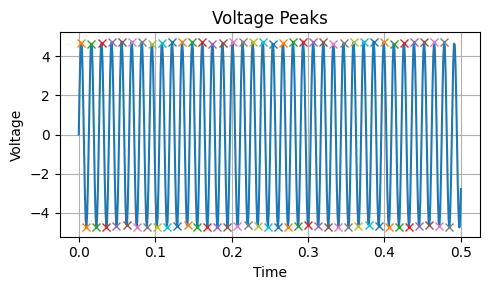

Freq: 149.49797570850208, Voltage: 9.411478816792233
Constant = 0.13 Nm/A


In [7]:
test_t = np.linspace(0, 0.5, 500) #example time array0
test_signal = (9.5/2) * np.sin(151.6 * np.pi * test_t) #example signal
#nice_plot_please(test_t,test_signal,"Test Signal","Time","Voltage")
example_data = {}
example_data["Test"] = {'times': test_t, 'voltages': test_signal}
test_constant = torque_finder("Test",example_data,21,True)
print(f"Constant = {round(test_constant, 2)} Nm/A")

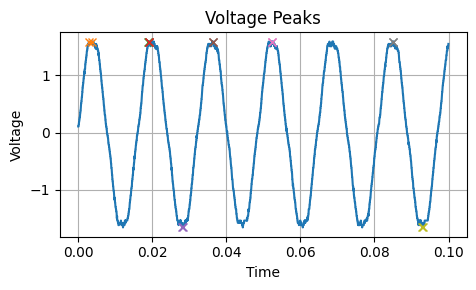

In [8]:
example = "RedF0001CH2"
(example_half_period,example_pk2pk)=waveform_data_info(example,plot=True)

In [9]:
all_back_emf = []
experiment_start_points=[0]
for experiment in centered_data:
    i=0
    #print(f"Experiment: {experiment}")
    back_emf = back_emf_finder(experiment, plot=False,filter=False)
    all_back_emf.extend(back_emf)
    experiment_start_points.append(all_back_emf[i]+len(all_back_emf))
    i+=1

NameError: name 'back_emf_finder' is not defined

Mean: 0.01681170425179227, Standard Deviation: 0.0023940940823635255


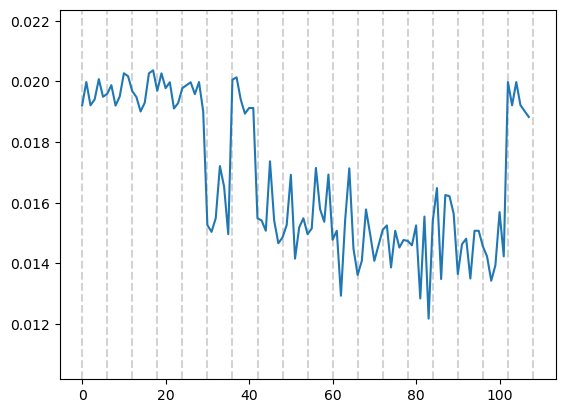

In [12]:
padding = 0.002
plt.vlines(experiment_start_points,min(all_back_emf)-padding,max(all_back_emf)+padding,color='lightgrey',linestyle='--')
plt.plot(all_back_emf)
plt.ylim(min(all_back_emf)-padding,max(all_back_emf)+padding)
print(f"Mean: {np.mean(all_back_emf)}, Standard Deviation: {np.std(all_back_emf)}")

#### Determining Constants  
Torque constant and back EMF constant found via:

$$K_b^q=K^q_t$$
Wye: $\bar V^H = \sqrt{2} V^q=\sqrt{2}K^q_b\frac{d\theta _m}{dt}$

Delta: $\bar V^H = \sqrt{\frac{2}{3}} V^q=\sqrt{\frac{2}{3}}K^q_b\frac{d\theta _m}{dt}$